# Payment Fraud Detection

The Payment Fraud Detection System aims to identify and mitigate fraudulent activities in financial transactions, specifically within payment systems. As digital transactions become increasingly prevalent, ensuring the security and integrity of financial operations is crucial for maintaining trust and safeguarding users from financial losses.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
dataset_path = '../datasets/paysim1/PS_20174392719_1491204439457_log.csv'

chunk_size = 100000
chunks = []
for chunk in pd.read_csv(dataset_path, chunksize=chunk_size):
    chunks.append(chunk)

data = pd.concat(chunks, ignore_index=True)

data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
data.shape

(6362620, 11)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
for col in data.columns:
    if data[col].dtype == object:
        print(col, ":", data[col].unique())

type : ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
nameOrig : ['C1231006815' 'C1666544295' 'C1305486145' ... 'C1162922333' 'C1685995037'
 'C1280323807']
nameDest : ['M1979787155' 'M2044282225' 'C553264065' ... 'C1850423904' 'C1881841831'
 'C2080388513']


In [6]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Data Visualization

Text(0.5, 1.0, 'Class Distribution')

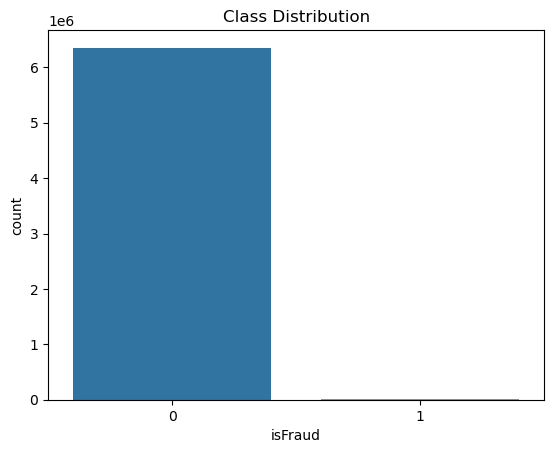

In [8]:
sns.countplot(data=data, x='isFraud')
plt.title("Class Distribution")

Text(0.5, 1.0, 'Distribution of type of Transactions')

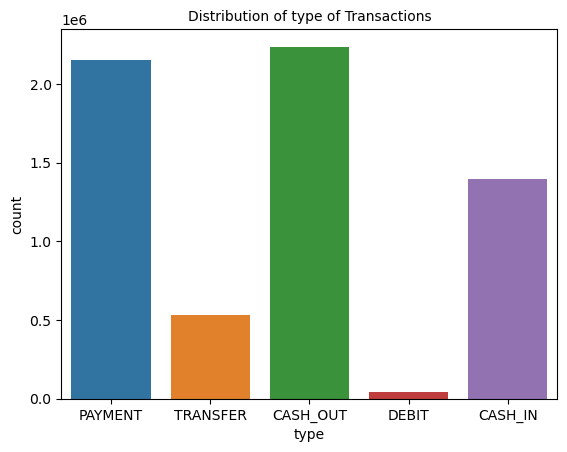

In [9]:
sns.countplot(data=data, x='type')
plt.title("Distribution of type of Transactions", fontsize=10)

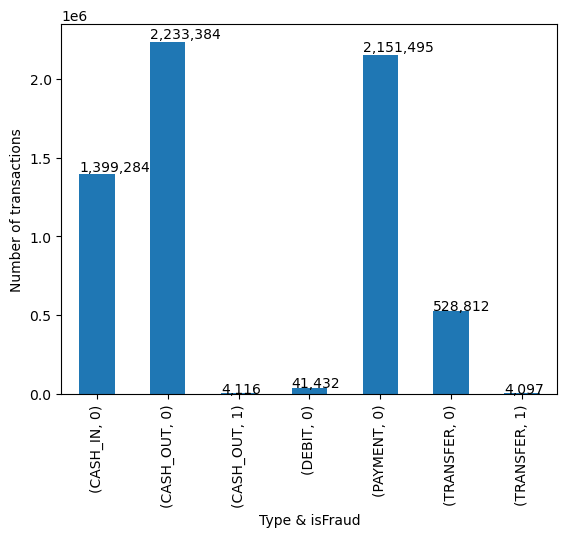

In [10]:
ax=data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title('')
ax.set_xlabel("Type & isFraud")
ax.set_ylabel("Number of transactions")
for t in ax.patches:
    ax.annotate(str(format(int(t.get_height()),',d')),(t.get_x(),t.get_height()*1.01))

### Data Preprocessing

In [11]:
#categorical data
data.select_dtypes(include='object').columns

Index(['type', 'nameOrig', 'nameDest'], dtype='object')

In [12]:
#numerical data
data.select_dtypes(include=["int64","float64"]).columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [13]:
data.drop(['nameOrig','nameDest'],axis=1,inplace=True)
data

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0


In [14]:
data['balance_diff'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['amount_to_balance_ratio'] = data['amount'] / (data['oldbalanceOrg'] + 1)

In [15]:
data = pd.get_dummies(data, columns=['type'], drop_first=True)

In [16]:
data.corr(numeric_only=False)["isFraud"].sort_values(ascending=False)

isFraud                    1.000000
balance_diff               0.362472
amount                     0.076688
type_TRANSFER              0.053869
isFlaggedFraud             0.044109
step                       0.031578
type_CASH_OUT              0.011256
oldbalanceOrg              0.010154
newbalanceDest             0.000535
type_DEBIT                -0.002911
amount_to_balance_ratio   -0.004915
oldbalanceDest            -0.005885
newbalanceOrig            -0.008148
type_PAYMENT              -0.025697
Name: isFraud, dtype: float64

In [17]:
X = data.drop(['isFraud'], axis=1)
y = data['isFraud']

In [18]:
scaler = StandardScaler()
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'balance_diff', 'amount_to_balance_ratio']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
X_train.shape, y_train.shape

((4453834, 13), (4453834,))

In [21]:
X_test.shape, y_test.shape

((1908786, 13), (1908786,))

### Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
lr_reg = LogisticRegression(max_iter=1000, random_state=42)
lr_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [24]:
# Evaluate
y_pred_lr = lr_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.90      0.49      0.63      2435

    accuracy                           1.00   1908786
   macro avg       0.95      0.74      0.82   1908786
weighted avg       1.00      1.00      1.00   1908786



In [25]:
def confusionMatrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

[[1906225     126]
 [   1246    1189]]


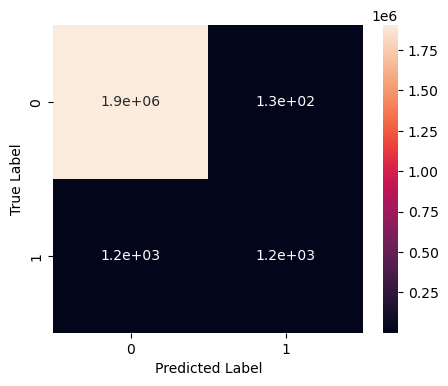

In [26]:
confusionMatrix(y_test, y_pred_lr)

### Random Forest Classifier

#### Using a Smaller Subset of Data for Initial Experimentation

In [28]:
# Sample a smaller subset of the data for initial experimentation
data_sample = data.sample(frac=0.1, random_state=42)  # Using 10% of the data
X_sample = data_sample.drop(['isFraud'], axis=1)
y_sample = data_sample['isFraud']

# Split the sampled data
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled_sample, y_train_resampled_sample = smote.fit_resample(X_train_sample, y_train_sample)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

rf = BalancedRandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf.fit(X_train_resampled_sample, y_train_resampled_sample)

C:\Users\suman\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\suman\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\suman\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

In [31]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:


C:\Users\suman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\suman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.00      0.00      0.00      2435

    accuracy                           1.00   1908786
   macro avg       0.50      0.50      0.50   1908786
weighted avg       1.00      1.00      1.00   1908786



C:\Users\suman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[1906351       0]
 [   2435       0]]


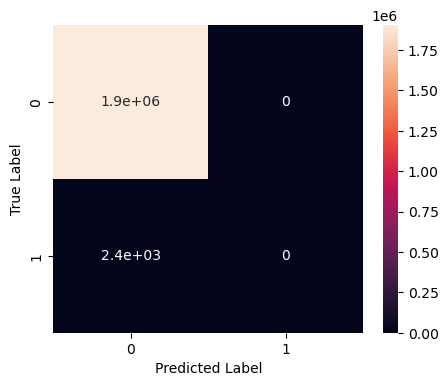

In [32]:
print("Confusion Matrix:")
confusionMatrix(y_test, y_pred_rf)

Random Forest Classifier can be very slow to train on large datasets due to its ensemble of multiple decision trees, which increases computational complexity and memory usage.

### Decision Tree Classifier

In [33]:
X = data.drop(columns=['isFraud'])
y = data['isFraud']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

##### Evaluation

In [37]:
y_pred_dt = dt_model.predict(X_test)
print("Accuracy:", dt_model.score(X_test, y_test))

Accuracy: 0.9997375295082843


[[635370     75]
 [    92    725]]
Confusion Matrix:
 None


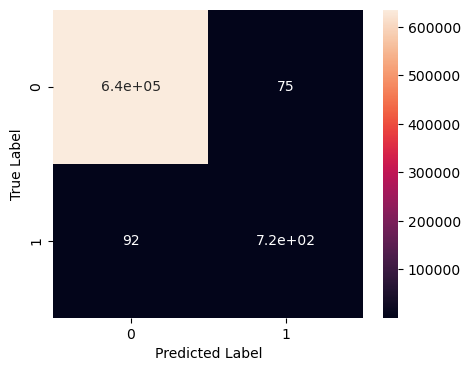

In [38]:
print("Confusion Matrix:\n", confusionMatrix(y_test, y_pred_dt))

In [39]:
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    635445
           1       0.91      0.89      0.90       817

    accuracy                           1.00    636262
   macro avg       0.95      0.94      0.95    636262
weighted avg       1.00      1.00      1.00    636262



### XGBoost (Extreme Gradient Boosting)

In [40]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [41]:
X_train_resampled.shape

(11437924, 13)

In [42]:
y_train_resampled.shape

(11437924,)

In [43]:
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False)
xgb.fit(X_train_resampled, y_train_resampled)

C:\Users\suman\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [44]:
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635445
           1       0.54      1.00      0.70       817

    accuracy                           1.00    636262
   macro avg       0.77      1.00      0.85    636262
weighted avg       1.00      1.00      1.00    636262



Confusion Matrix:
[[634764    681]
 [     2    815]]


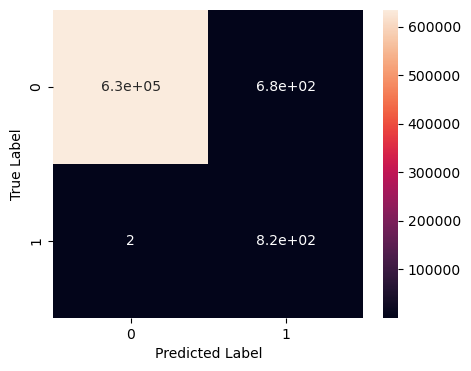

In [45]:
print("Confusion Matrix:")
confusionMatrix(y_test, y_pred_xgb)

In [46]:
# ROC AUC Score
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]
print("XGBoost ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))

XGBoost ROC AUC Score: 0.9995763057477439


In [54]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_dist_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False),
    param_distributions=param_dist_xgb,
    n_iter=4,
    cv=2,
    verbose=1,
    n_jobs=-1,
    scoring='roc_auc'
)

# Fit the model
random_search_xgb.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_xgb = random_search_xgb.best_estimator_

Fitting 2 folds for each of 4 candidates, totalling 8 fits


C:\Users\suman\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [19:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [56]:
from sklearn.metrics import accuracy_score

y_pred_xgb = best_xgb.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Accuracy Score:\n", accuracy_score(y_test, y_pred_xgb))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    635445
           1       0.48      1.00      0.65       817

    accuracy                           1.00    636262
   macro avg       0.74      1.00      0.83    636262
weighted avg       1.00      1.00      1.00    636262

Accuracy Score:
 0.998623208678186


Based on the performance and training times of various models, I have decided to use the XGBoost model for the further processes of this payment fraud detection project.

Here are the key reasons for this decision:

1. **Fast Training Time**: Among the models tested (Logistic Regression, Random Forest, Decision Tree, and XGBoost), the XGBoost model trained the fastest while maintaining high accuracy and performance.

2. **High Performance**: XGBoost provided a highly accurate model.

3. **Handling Imbalanced Data**: XGBoost has in-built techniques for handling imbalanced datasets, which is crucial for fraud detection tasks where fraudulent transactions are much rarer compared to non-fraudulent ones.

4. **Feature Importance**: XGBoost provides robust methods for evaluating feature importance, which helps in understanding the factors contributing to fraud.

5. **Scalability and Efficiency**: XGBoost is highly scalable and can efficiently handle large datasets, making it suitable for real-time fraud detection scenarios.

Given these benefits, the XGBoost model is well-suited for the project's requirements and will be used for the remaining tasks in this project.

In [59]:
import joblib
import os

save_path = '../xgboost_fraud_detection_model.joblib'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

joblib.dump(best_xgb, save_path)

['../xgboost_fraud_detection_model.joblib']

In [60]:
# Load the trained model
model = joblib.load('xgboost_fraud_detection_model.joblib')